# Principal Component Analysis

Principal Component Analysis (PCA) is a statistical technique used to **reduce the dimensionality** of a dataset while preserving as much variance as possible.

As a (not so rigorous) analogy for dimensionality reduction, think of image compression.

A raw picture has a lot of pixels (dimensions) which can make its size rather big. 
However, you can selectively remove some information from it (i.e. compression), and the reconstructed image, like the ones you usually see on the web,
is still nice enough for most purposes.

At the core, the key rationale is that _"the information in a high-dimensional vector can be represented, to a large extent, by a smaller number of dimensions"_.

Today we will see it by working with human faces. 
Though complicated as it may seem, an image of human face can be represented by a relatively small number of dimensions.

## 1. The Olivetti Faces Dataset
Between April 1992 and April 1994, a set of 400 images of 40 different subjects was collected at AT&T Laboratories Cambridge.
At that time, the images were used to build a face recognition system.

Today we will play with this dataset, now called The Olivetti Faces Dataset, to see how PCA works.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

In [2]:
# This will download the Olivetti faces dataset if not already present
faces = fetch_olivetti_faces(
    data_home="./data", random_state=42, download_if_missing=True
)

n_samples, h, w = faces.images.shape
X = faces.data
n_features = X.shape[1]
y = faces.target
n_classes = len(np.unique(y))

print("Dataset dimensions:")
print(f"- Number of samples: {n_samples}")
print(f"- Image height: {h}")
print(f"- Image width: {w}")
print(f"- Total features per image: {n_features}")
print(f"- Number of people (classes): {n_classes}")
print(f"- Images per person: {int(n_samples / n_classes)}")

Dataset dimensions:
- Number of samples: 400
- Image height: 64
- Image width: 64
- Total features per image: 4096
- Number of people (classes): 40
- Images per person: 10


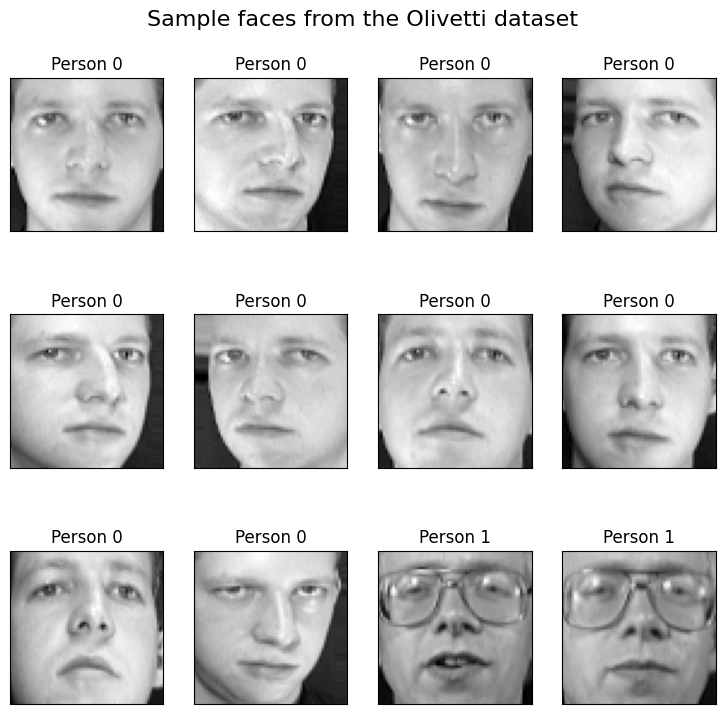

In [3]:
# Take a look at those faces


def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap="gray")  # type: ignore
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# Plot a selection of faces from the dataset
n_samples_to_plot = min(12, n_samples)
sample_titles = [f"Person {i}" for i in faces.target[:n_samples_to_plot]]
plot_gallery(faces.data[:n_samples_to_plot], sample_titles, h, w)
plt.suptitle("Sample faces from the Olivetti dataset", size=16)
plt.show()

## 2. "Compressing the Faces"

Now we can regard each image as a vector in a 4096-dimensional space (64x64 pixels).

The `PCA` class in `sklearn.decomposition` is used to perform PCA on a set of data, reducing its dimensionality while preserving as much variance as possible.

We will see if we can compress the images to a lower dimensionality and still be able to recognize the faces when it is reconstructed back.

In [4]:
# Create a PCA model
pca = PCA(n_components=256, random_state=42)
# Fit the model to the data
pca.fit(X)

PCA(n_components=256, random_state=42)

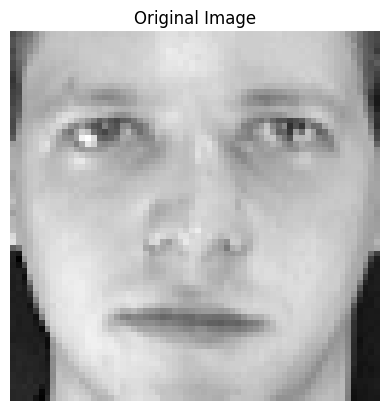

In [5]:
# Now we pick a sample image to project
sample_image = X[0].reshape(1, -1)
plt.imshow(sample_image.reshape(h, w), cmap="gray")  # type: ignore
plt.title("Original Image")
plt.axis("off")
plt.show()

In [6]:
# Project the sample image into PCA space
sample_image_pca = pca.transform(sample_image)
print(f"Projected vector shape: {sample_image_pca.shape}")

Projected vector shape: (1, 256)


You can see that we have removed a substantial portion of the information from the original vector.

Let's now see what will happen if we try to reconstruct the image from the compressed version.

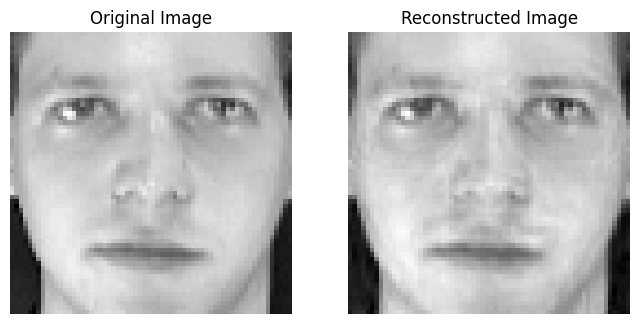

In [7]:
# Reconstruct the image from PCA space
sample_image_reconstructed = pca.inverse_transform(sample_image_pca)
# Show the reconstructed image and the original image
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(sample_image.reshape(h, w), cmap="gray")  # type: ignore
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(sample_image_reconstructed.reshape(h, w), cmap="gray")  # type: ignore
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")
plt.show()

Wow! Not bad at all!

We removed over 90% of the information from the original image (256 compare to 4096), and we can still get a pretty nice reconstruction of the original image.

In fact, we can visualize how much those dimensions after compression have contributed to the variances to the original dataset. This could be retrieved from the `explained_variance_ratio_` attribute of the PCA object.

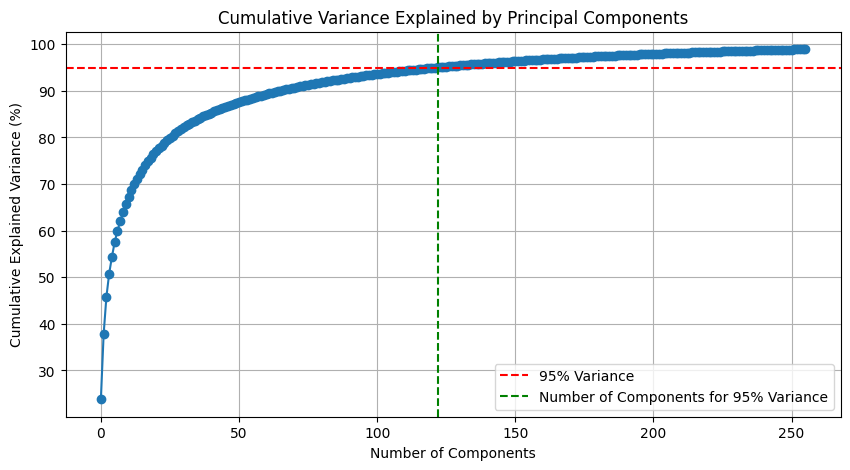

In [8]:
# Display the cumulative variance
plt.figure(figsize=(10, 5))
# np.cumsum computes the cumulative sum of along the specified axis
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
plt.plot(cumulative_variance, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Cumulative Variance Explained by Principal Components")
plt.grid()
plt.axhline(y=95, color="r", linestyle="--", label="95% Variance")
plt.axvline(
    x=float(np.argmax(cumulative_variance >= 95)),
    color="g",
    linestyle="--",
    label="Number of Components for 95% Variance",
)
plt.legend()
plt.show()

This, to some extent, proves our statement at the beginning of this notebook that _the information in a high-dimensional vector can be represented, to a large extent, by a smaller number of dimensions_.

> 📚 **EXERCISE**
>
> - Try to further reduce the dimensionality of the images (128, 64, etc.) and see at what point the reconstruction starts to look unacceptable.
> - Compare your results with the explained variance ratio graph above. Did your observations match what the graph shows?

In [9]:
# === Your code here ===

## 3. The eigenfaces

You may well ask,

_"Well then, you have compressed the original vector into a smaller number of components, but are there any semantic meanings to those components?"_

The answer is yes! It actually has a specific name: **eigenfaces**.

> *The eigenface approach began with a search for a low-dimensional representation of face images. Sirovich and Kirby showed that principal component analysis could be used on a collection of face images to form a set of basis features. These basis images, known as eigenpictures, could be linearly combined to reconstruct images in the original training set.*
>
> -- [Eigenface, Wikipedia](https://en.wikipedia.org/wiki/Eigenface)

Let's write some code to prove they are indeed correct.

First, let us center the data by substracting the "mean face", i.e. the average of all faces in the dataset.

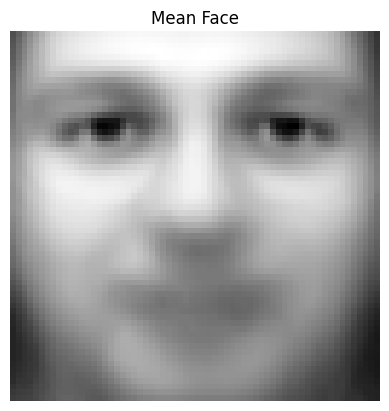

In [10]:
mean_face = np.mean(X, axis=0)
# Plot the mean face
plt.imshow(mean_face.reshape(h, w), cmap="gray")
plt.title("Mean Face")
plt.axis("off")
plt.show()

At least it looks like a face :3

In [11]:
X_centered = X - mean_face

# Apply PCA to the centered data
pca_centered = PCA(n_components=256, random_state=42)
pca_centered.fit(X_centered)

PCA(n_components=256, random_state=42)

Now, as you might have guessed, the components of the PCA object are the eigenfaces.

Let us visualize the first few eigenfaces.

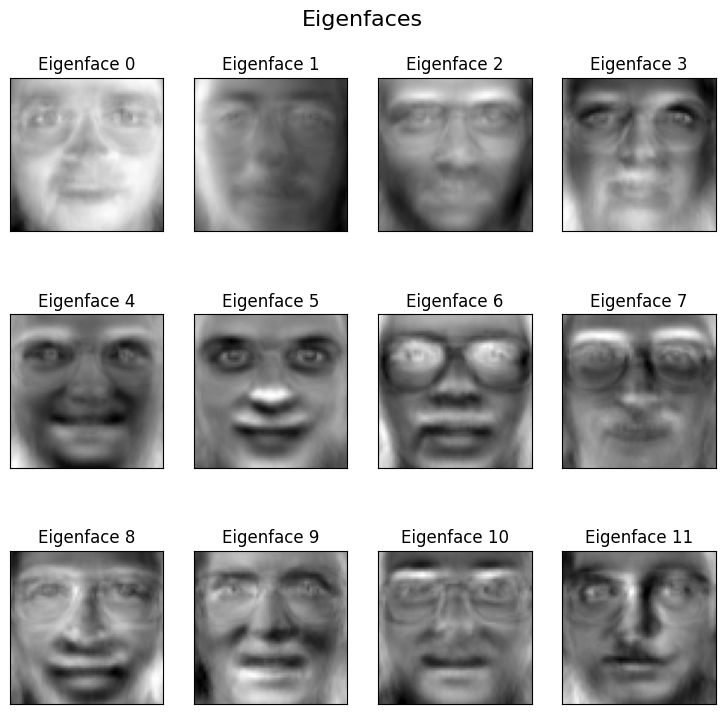

In [12]:
eigenfaces = pca_centered.components_.reshape((pca_centered.n_components_, h, w))
# Plot the first 12 eigenfaces
plot_gallery(eigenfaces, [f"Eigenface {i}" for i in range(12)], h, w)
plt.suptitle("Eigenfaces", size=16)
plt.show()

Now, although the images are a little bit creepy 😱, 
the faces in this dataset can indeed be represented as a linear combination of the eigenfaces.

For example, a human face can be represented as 35% of the first eigenface, 25% of the second eigenface, and so on.
And as you have seen in the second section, the reconstructed face still looks relatively reasonable and nice.

> 🤔 **THINKING**
>
> - In many of the deep neural networks, you may have heard of the term "feature extraction", 
> and many neural networks have something called a "bottleneck" layer
> which has its dimensionality far smaller than the input layer.
> Can you explain its rationales based on what you have learned today?
> - Read about the [Manifold Hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis).
> How do you think it justifies the possibility of dimensionality reduction?
> - Do you know more dimensionality reduction techniques beyond PCA? Investigate them.

## 4. Bonus: PCA for visualization

Remember that in previous sections we have to use only two features to run the classification task on Iris dataset in order to visualize the results?

Now you have learnt PCA, you can use it to reduce the dimensionality of the dataset and visualize the results.
`Yellowbrick` has a `PCA` visualizer that can help you with that, which automatically reduces the dimensionality of the dataset to 2D and plots the datapoints in the new space.

This is another important usage of dimensionality reduction.

What's more, although not in this case,
because of the feature-extraction capability of PCAs, 
there is a chance that a direct look at high-dimensional data can find some hints about the underlying structure of the data!

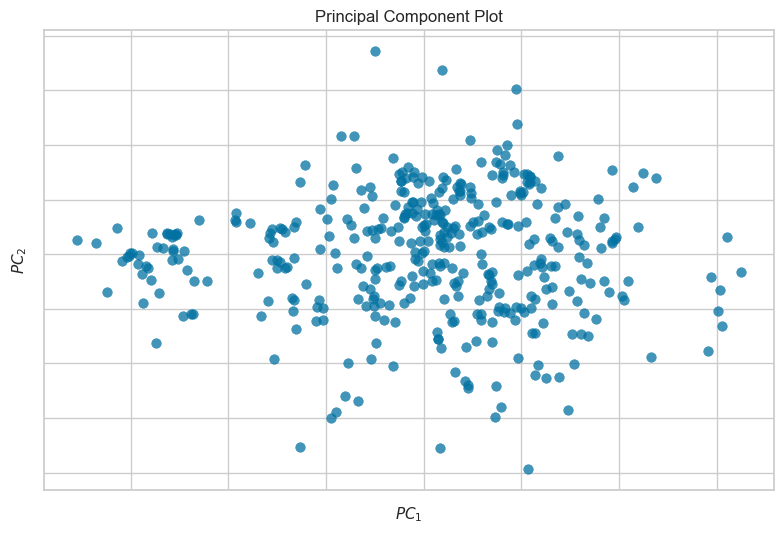

PCA(ax=<Axes: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>)

In [13]:
from yellowbrick.features import pca_decomposition

# One-liner for dimensionality reduction + visualization
pca_decomposition(X, projection=2)